# Citi Bike Pandemic Demand Forecasting 
### Ian Klasky
#### Oct 26, 2020

In this notebook I implement, and *breifly* analyze a model to predict the demand of Citi Bike trips for the fourth quarter of 2020.

In a previous [notebook](https://nbviewer.jupyter.org/github/iklasky/Springboard/blob/master/bikes/Forecasting_Covid_Blue_Bikes.ipynb) I performed an extended analysis on different statistical models and their abilities to forecast bikesharing demand in the midst of the behavioral anomalies caused by the current pandemic. Facebook's Phophet forecasting model performed the best in this analysis when backtesting to historical data - both before and after the beginning of the COVID-19 outbreak.

The model constructed in this notebook forecasts around a 9.5% increase in Citi Bike trips in the fourth quarter of 2020 compared to the the number of trips in the fourth quarter of 2019.

This (mini) notebook has two sections:

* [Preprocessing](#Preprocessing)
* [Modeling & Forecasting](#Modeling_Forecasting)

## Preprocessing<a name="Preprocessing"></a>

In the following cells the packages and data used for the analysis will be read in. A csv of containing the number of Citi Bike trips per day from January 2016 to September 2020 has already been generated from the publicly available Citi Bike [datasets](https://s3.amazonaws.com/tripdata/index.html) using a separate script. The data is further cleaned in cells 4 and 5.

In [1]:
import os.path
import pandas as pd
import datetime as dt
from datetime import timedelta
import fbprophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_agg_data():
    
    path = '/Users/ianklasky/Desktop/Springboard/bikes/'
    
    if os.path.isfile('citi_bike.csv'):
        df = pd.read_csv(path+'citi_bike.csv', index_col=0, parse_dates=True)

    return df

In [3]:
df = read_agg_data()

In [4]:
def fix_dates(df):
    
    df.drop_duplicates(inplace=True)
    
    df.index.rename('date',inplace=True)
    df.reset_index(inplace=True,drop=True)

    return df

In [5]:
df = fix_dates(df)
df.head()

,date,trips
0,2016-01-01,11009
1,2016-01-02,14587
2,2016-01-03,15499
3,2016-01-04,19593
4,2016-01-05,18053


Below is a graph of the resulting time series of Citi Bike trips per day from Jan 2016 to Sept 2020.

In [6]:
def plot_ts(df):
    
    plt.figure(figsize=(13, 8))
    plt.plot(df.date,df.trips)
    plt.ylabel('Trips',rotation=0,size=15)
    plt.xlabel('Date',rotation=0,size=15)
    
    #plt.tick_params(axis='x', which='major', labelsize=13)
    plt.show()
    
    return

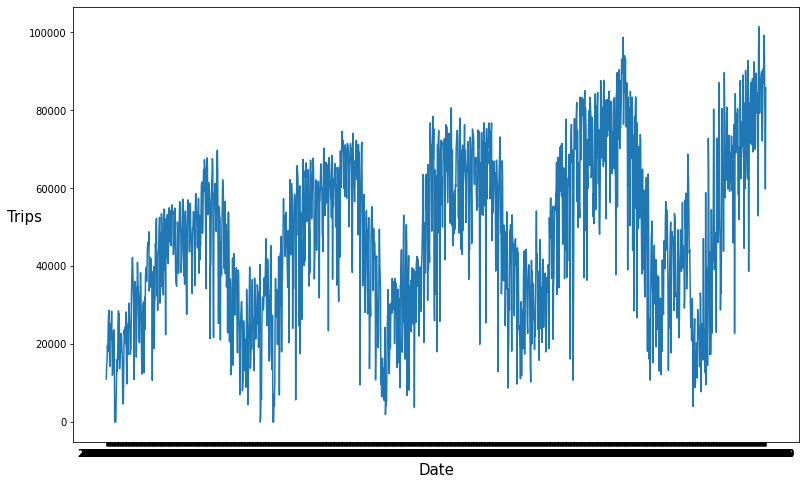

In [7]:
plot_ts(df)

## Modeling & Forecasting<a name="Modeling_Forecasting"></a>

In the cells below we train our Prophet model on the Citi Bike daily trip data from Jan 2016 through Sept 2020 and forecast demand for the rest of 2020.

In [8]:
def make_forecast(df,changepoint,changepoint_prior_scale):
    
    if 'date' in df.columns:
        df_forecast = df.rename(columns={'date':'ds','trips':'y'})
    
    model = fbprophet.Prophet(changepoints = changepoint,
                              changepoint_prior_scale = changepoint_prior_scale,
                              interval_width=0.95)
    model.fit(df_forecast)
    
    future = model.make_future_dataframe(periods=92)
    forecast = model.predict(future)
    
    model.plot(forecast[len(forecast)-92:]);
    
    start_idx = df_forecast.loc[df_forecast['ds'] == str((forecast.ds[len(forecast)-1-92] - timedelta(days=365)).date())].index.values[0]
    end_idx = df_forecast.loc[df_forecast['ds'] == str((forecast.ds[len(forecast)-1] - timedelta(days=365)).date())].index.values[0]

    return (round(forecast.loc[len(forecast)-92:].trend.sum() / df_forecast[start_idx:end_idx].y.sum(),4) - 1) * 100

In [9]:
def inc_or_dec(percent_diff):
    
    if percent_diff > 0:
        return 'increase'
    elif percent_diff < 0:
        return 'decrease'
    
    return 'change'

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


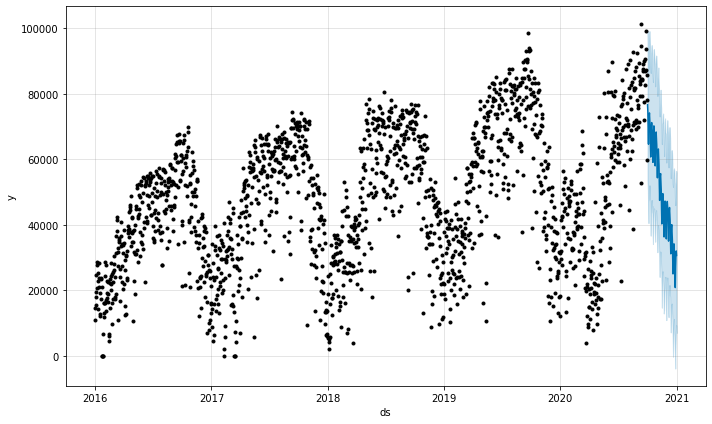

In [10]:
percent_diff = make_forecast(df,['2020-03-08'],0.9)

The graph above shows the historic trips per day as well as the forecast for October through December of 2020. The dark blue line represents the forecast for each day in this time window, while the lighter blue area around it shows the 95% confidence interval of the predictions.

Our model predicts a **{{percent_diff}}% {{inc_or_dec(percent_diff)}}** in trips in the fourth quarter of 2020 compared to the number of trips in the fourth quarter of 2019.

Thanks for reading! Please send any questions/commments/concerns to ian.klasky@gmail.com.

Stay safe!